# Data Exploration

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [9]:
predictors = pd.read_csv('data/water_table_training.csv')
target = pd.read_csv('data/water_table_labels.csv')

In [10]:
df = predictors.merge(target, on = 'id')
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [11]:
##selecting which columns to drop based off impact on prediction and overlapping information
columns = ['id', 'date_recorded', 'installer', 'wpt_name', 'num_private', 'region', 'subvillage', 
           'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'water_quality', 
           'quantity', 'source_type', 'waterpoint_type_group', 'public_meeting']

In [14]:
cleaned_df = df.drop(columns = columns, axis = 1)
cleaned_df.dropna(inplace = True)

cleaned_df.columns

Index(['amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'population',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')

In [9]:
#sns.pairplot(cleaned_df[numerical_columns])

count    51329.000000
mean      1334.765552
std        940.138379
min          0.000000
25%          0.000000
50%       1987.000000
75%       2005.000000
max       2013.000000
Name: construction_year, dtype: float64 
Mode: 0    2008.0
dtype: float64


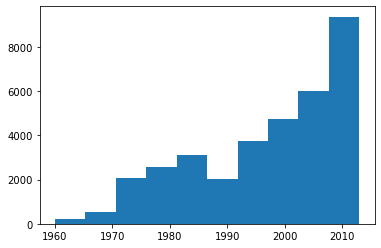

In [19]:
##checking to see distribution of non-zero(np.nan) values to determine how to impute
## will impute with mode

print(cleaned_df.construction_year.describe(), '\nMode:', cleaned_df.construction_year.replace(0.0, np.nan).mode())
plt.hist(cleaned_df.construction_year.replace(0.0, np.nan));

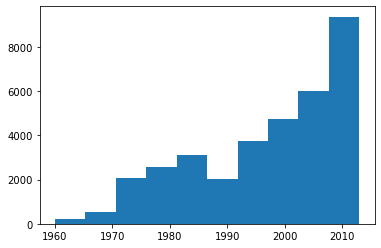

In [21]:
cleaned_df.construction_year.replace(0.0, np.nan, inplace = True)
plt.hist(cleaned_df.construction_year);

In [22]:
#replacing string values for status group with 0, 1, or 2 in 'status_no'

conditions = [cleaned_df['status_group'] == 'non functional', cleaned_df['status_group'] == 'functional needs repair', cleaned_df['status_group'] == 'functional']
choices = [0,1,2]

cleaned_df['status_no'] = np.select(conditions, choices)
cleaned_df.drop('status_group', axis = 1, inplace = True)


# First Model with Cleaned Data

In [24]:
cleaned_df.columns

Index(['amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'population',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'status_no'],
      dtype='object')

In [29]:
##Separating predictor feature columns into categorical and continuous value groups

#continuous features
numerical_columns = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']

#categorical features without the target of 'status_group'
categorical_columns = cleaned_df.select_dtypes(include = 'object').columns

categoricals1 = ['funder', 'basin', 'lga', 'extraction_type', 'management', 'source']
categoricals2 = ['region_code', 'scheme_management', 'permit', 'extraction_type_class', 'management_group', 'quality_group', 'quantity_group']

In [30]:
categorical_columns

Index(['funder', 'basin', 'lga', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

X = cleaned_df.drop('status_no', axis = 1)
y = cleaned_df['status_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [13]:
X_train_cats = X_train[smaller_categoricals]
X_train_nums = X_train[numerical_columns]

X_test_cats = X_test[smaller_categoricals]
X_test_nums = X_test[numerical_columns]

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [14]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train))
X_train_imputed.columns = X_train.columns

In [15]:
ohe_train = OneHotEncoder(drop = 'first', sparse = False)

ohe_train.fit(X_train_cats)

X_train_enc = pd.DataFrame(ohe_train.transform(X_train_cats))

In [16]:
X_train_enc

,0,1,2,3,4,5,6,7,8,9,...,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_train_imputed.drop(columns = X_train_cats.columns, inplace = True)
X_train_transformed = pd.concat([X_train_imputed, X_train_enc], axis = 1)

In [18]:
logreg_larj = LogisticRegression(random_state=2021, max_iter=5000)
logreg_larj.fit(X_train_transformed, y_train)

ValueError: could not convert string to float: 'VWC'